In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
#import _pickle as pickle
import pickle
import re, sys, unidecode
#import unidecode

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil
import os

# Representation
import nltk
from nltk.corpus import stopwords
import scikitplot as skplt

import wordbatch
from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL

from tensorflow.contrib.learn import DNNClassifier

#from tecnosmartlib import DataObject

#plt.style.use('fivethirtyeight')

#Carga stop word
nltk.download('stopwords')
spanish_stopwords = nltk.corpus.stopwords.words('spanish')

# punkt:  módulo contiene modelos para la tokenización de textos
nltk.download('punkt')


import lightgbm as lgb
from sklearn.metrics import mean_squared_error

/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so | _pywrap_tensorflow_internal
/root/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/lite/toco/python/_tensorflow_wrap_toco.so | _tensorflow_wrap_toco
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Parameters

In [2]:
root_path = "../"
path_data_clean = root_path + "data/clean/"
path_model = root_path + 'models/'
features_path = root_path + 'data/features/'
model_name = "test"
path_model += model_name

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

In [3]:
dfNoticias = pd.read_pickle(path_data_clean + "/dfNoticiasClean.p")


In [4]:
dfNoticias.head()

,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
1,\nMarcel Granollers (44°) sorprendió a David F...,20140929,09:57,20140929095927,\nEl español cayó ante su compatriota Marcel G...,deportes,None,None,torneos atp,None,None,tenis,None,None,\nDavid Ferrer sufrió otra temprana eliminación\n,fid_noticia
2,\nEl Gobierno de Barack Obama ha enviado cuatr...,20140929,07:03,20140929065051,\nLas conversaciones comenzaron el año 2010 y ...,pais,mundo,mundo,eeuu,relaciones exteriores,None,relaciones exteriores,eeuu,cuba,\nObama ha enviado cuatro solicitudes a Chile ...,fid_noticia
3,\nEste miércoles la Comisión Asesora Presidenc...,20140929,11:37,20140929105234,\nRepresentantes del sector privado acusaron q...,pais,None,None,isapre,None,None,salud,None,None,\nQuiebre en comisión presidencial de isapres ...,fid_noticia
4,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929100825,\nEl pedalero del equipo Avanti terminó en el ...,deportes,None,None,chilenos,None,None,ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia
6,"\nEl Gobierno, a través de Sernapesca, present...",20140929,15:47,20140929152501,\nBachelet instruyó a los ministros de Economí...,pais,pais,None,None,None,None,medioambiente,region de valparaiso,None,\nGobierno presentó querella por derrame de pe...,fid_noticia


# pre procesing



In [5]:
_map = {}
_map["Cuerpo"] = []
_map["Seccion"] = []
_map["Subtema"] = []

count = 0
for index, row in dfNoticias.iterrows():    
    _map["Cuerpo"].append(row["Cuerpo"]) 
    _map["Seccion"].append(row["Seccion_1"])
    _map["Subtema"].append(row["Subtema_1"])

df = pd.DataFrame(_map)  
    
X_untransformed = df['Cuerpo'].reset_index(drop=True)
y_untransformed = df['Seccion'].reset_index(drop=True)


# Feature Extraccion

### Data representation
* Normalisacion
* TFID calculation

In [6]:
from nltk.stem.snowball import SnowballStemmer



# def normalize_text(text):
#     """ Funcion de normalizacion """    
#     # split into words
#     tokens = nltk.tokenize.word_tokenize(text,language='spanish', preserve_line=False)
#     # convert to lower case
#     tokens = [w.lower() for w in tokens]    
    
#     # remove punctuation from each word
#     table = str.maketrans('', '', string.punctuation)
#     stripped = [w.translate(table) for w in tokens]
    
#     # remove remaining tokens that are n<<<<<<<<<<<<<<<<<<<<<
#     words = [word for word in stripped if word.isalpha()]
    
#     # stop word and remove accent
#     def strip_accents(s):
#         return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
#     stop_words = set(spanish_stopwords)
#     words = [strip_accents(w) for w in words if not w in stop_words]

#     # return u" ".join(words)
    
#     stemmer = SnowballStemmer("spanish")
#     out = ""
#     for word in words:
#         out += stemmer.stem(word)+" "
    
#     return out
    

spanish_stopwords = stopwords.words('spanish')
def normalize_text(text):
    return u" ".join([x for x in [y for y in text.lower().strip().split(" ")] 
                      if len(x) > 1 and x not in spanish_stopwords])

In [7]:
# true calcula features, false carga si ya estan calculadas
calc_tfid = False

features_path = features_path + "tfid_hash28_n1000.p"

if calc_tfid :
    start = time.time()
    print("start")


    X_untransformed = X_untransformed
    n_docs = X_untransformed.shape[0]
    n_cpu = 20

    batch_size = int(n_docs/n_cpu)

    #'log', "idf":50.0
    
    wb = wordbatch.WordBatch(normalize_text, 
                             extractor=(WordBag, {"hash_ngrams": 1, "hash_ngrams_weights": [1.0, 1.0],
                                                  "hash_size": 2**28, "norm": "l2", "tf": 1.0,
                                                  "idf": 1.0}), procs=n_cpu, n_words=1000, minibatch_size=batch_size)

#     wb = wordbatch.WordBatch(normalize_text, 
#                              extractor=(WordBag, {"hash_ngrams": 2, "hash_ngrams_weights": [-1.0, -1.0],
#                                                   "hash_size": 2**22, "norm": "l2", "tf": 1.0,
#                                                   "idf": 1.0}), procs=n_cpu, n_words=10000, minibatch_size=batch_size)
    
    
    
    wb.dictionary_freeze = True
    word_comment = wb.fit_transform(list(X_untransformed),reset= False)
    # revisar esta normalizacion
    X_transformed = word_comment[:, np.array(np.clip(word_comment.getnnz(axis=0) - 1, 0, 1), dtype = bool)]

    end = time.time()
    print("TFIDF end time :" + str(end - start) )

    X = X_transformed

    #X = X.todense()
    print('Number of features: {}'.format(X.shape[1]))

    pickle.dump( X, open( features_path, "wb" ) )
else:    
    X = pickle.load( open( features_path, "rb" ) )

### filter clases

In [8]:
y = y_untransformed.values
labels = list(set(y))
umbral = 100
sizes = [ [label,y[y== label].shape[0]] for label in labels ]
filter_sizes = list(filter(lambda x:x[1]>umbral ,sizes ))
names_clases = set( map(lambda x:x[0], filter_sizes ) )

index = list(map(lambda x: {x}.issubset(names_clases), y ))

y = y[index]
X = X[np.nonzero(index)]


### Output

In [9]:
np.random.seed(42)

train_fraction = 0.8

train_indices = np.random.choice(X.shape[0], round(train_fraction*X.shape[0]), replace=False)
test_indices = np.array(list(set(range(X.shape[0])) - set(train_indices)))

X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [29]:
labels = list(set(y))
labels.sort()
nClasses = len(labels)

sizes = {label: y_train[y_train == label].shape[0] for label in labels}
weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
weights = np.power(weights,3) # 1.4

# #lerko
# scale_factor = 10e3
# sizes = {label: y_train[y_train == label].shape[0] for label in labels}
# weights = np.asarray([scale_factor/sizes[label] for label in y])

weights_train = weights[train_indices]
weights_test = weights[test_indices]


In [11]:
weights = np.power(weights,2)
set(weights)

{0.028118532318818334,
 0.029984782878777174,
 0.7864775946580234,
 1.0540851122731871,
 91.79533267638075,
 232.61878017312176,
 287.3771058677976,
 5400.325439815967}

In [12]:
labels

y_train_new = []
for yTmp in y_train:
    for idx, label in enumerate(labels):
        if yTmp==label: 
            y_train_new.append(idx)
            
y_test_new = []
for yTmp in y_test:
    for idx, label in enumerate(labels):
        if yTmp==label: 
            y_test_new.append(idx)            


# Model



In [13]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train_new, weight= weights_train)
#lgb_train = lgb.Dataset(X_train, y_train_new)
lgb_eval = lgb.Dataset(X_test, y_test_new, reference=lgb_train)


In [27]:
# specify your configurations as a dict
# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'multiclass',
#     'num_class':nClasses,
#     'metric' : "multi_logloss",
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 1,
#     #'
# }

# leave 31 def
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':nClasses,
    'metric': 'multi_logloss',
    'learning_rate': 0.4,#0.4
    'min_data_in_leaf':60, #60 ,50     
    'max_depth':-1,
    'num_leaves': 71,#31 , 71
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': -1,
    'verbose': 1,    
    'num_threads':20}

start = time.time()
print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=6,
                )

end = time.time()
print("training time :" + str(end - start) )

Start training...
[1]	valid_0's multi_logloss: 1.67276
Training until validation scores don't improve for 6 rounds.
[2]	valid_0's multi_logloss: 1.55909
[3]	valid_0's multi_logloss: 1.48669
[4]	valid_0's multi_logloss: 1.43985
[5]	valid_0's multi_logloss: 1.40693
[6]	valid_0's multi_logloss: 1.37731
[7]	valid_0's multi_logloss: 1.35115
[8]	valid_0's multi_logloss: 1.32051
[9]	valid_0's multi_logloss: 1.29681
[10]	valid_0's multi_logloss: 1.26752
[11]	valid_0's multi_logloss: 1.24063
[12]	valid_0's multi_logloss: 1.21586
[13]	valid_0's multi_logloss: 1.18445
[14]	valid_0's multi_logloss: 1.15685
[15]	valid_0's multi_logloss: 1.13087
[16]	valid_0's multi_logloss: 1.10518
[17]	valid_0's multi_logloss: 1.08136
[18]	valid_0's multi_logloss: 1.05836
[19]	valid_0's multi_logloss: 1.03571
[20]	valid_0's multi_logloss: 1.0151
[21]	valid_0's multi_logloss: 0.99531
[22]	valid_0's multi_logloss: 0.978661
[23]	valid_0's multi_logloss: 0.96221
[24]	valid_0's multi_logloss: 0.946397
[25]	valid_0's mu

# performance


/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


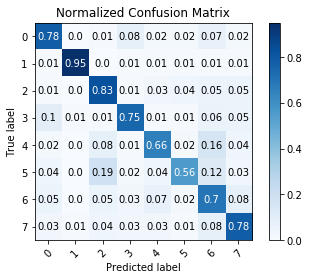

## Accuracy in test: 74.33632024118583 

In [24]:
preds =  gbm.predict(X_test)
predictions = []
for x in preds:
    predictions.append(np.argmax(x))
    
y_test_hat = predictions


skplt.metrics.plot_confusion_matrix(y_test_new, y_test_hat,normalize=True)
plt.xticks(rotation=45)
plt.show()

acc = accuracy_score(y_true=y_test_new, y_pred=y_test_hat)

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


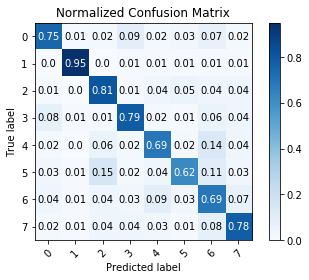

## Accuracy in test: 77.02872456243196 

In [28]:
preds =  gbm.predict(X_test)
predictions = []
for x in preds:
    predictions.append(np.argmax(x))
    
y_test_hat = predictions


skplt.metrics.plot_confusion_matrix(y_test_new, y_test_hat,normalize=True)
plt.xticks(rotation=45)
plt.show()

acc = accuracy_score(y_true=y_test_new, y_pred=y_test_hat)

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))